<a href="https://colab.research.google.com/github/mayarachew/IronyDetectionInTweets/blob/main/irony_detection_EN_ulmfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install -U fastai
!pip install fastcore
!pip install -Uqq fastbook

import fastbook

fastbook.setup_book()

In [ ]:
!cp -r "/content/drive/My Drive/sentiment_analysis/irony_detection_EN_taskA" "irony_detection_EN"
!cp -r "/content/drive/My Drive/sentiment_analysis/irony_detection_pt2" "irony_detection_pt2"

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import itertools
import nltk
from nltk.corpus import stopwords
from fastai.text.data import *
from fastai import *
from fastai.basics import *
from fastbook import *
from fastai.text.all import *
from IPython.display import display,HTML
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Path variables

In [ ]:
path = Path("/content/gdrive/MyDrive/sentiment_analysis/irony_detection_EN_taskA/")

Hyperparameters

In [ ]:
n_epochs = 5
SEED = 10
debug = 0

In [ ]:
df_train = pd.read_csv(path/"SemEval2018-T3-train-taskA.txt", sep='\t',encoding="UTF-8",low_memory = False)
df_valid = pd.read_csv(path/"SemEval2018-T3-valid-taskA.txt", sep='\t',encoding="UTF-8",low_memory = False)
df_test = pd.read_csv(path/"SemEval2018-T3_gold_test_taskA_emoji.txt", sep='\t',encoding="UTF-8",low_memory = False)

df_train .head()

,Tweet index,Tweet text,Label
0,2248,Beautiful day,1
1,156,@Moose_eBooks You seriously bought a giant TV to play in the box?,0
2,2831,@NewDay: .@JebBush considering a run for the @WhiteHouse: http://t.co/nq5JO2ZrQ6 #5Things http://t.co/HC74bNlZuT <shocking> <>,1
3,842,a bad game last night. Way to go Packers! http://t.co/9vvSvsEnmF,0
4,20,"But @DarklightDave was trying to find us, and my battery died. Guess how he found us? Yes, that bastard wand! !!!!!",1


Preprocessing of the Dataframe: some shit going on with Fastai

In [ ]:
# Add a is_valid colum. The ColSplitter() function below expects this column.
df_valid['is_valid'] = True

# Add a is_valid colum
df_train['is_valid'] = False

In [ ]:
# Stack the two dataframes into one.
df = pd.concat([df_train,df_valid], ignore_index=True)
df.head()

,Tweet index,Tweet text,Label,is_valid
0,2248,Beautiful day,1,False
1,156,@Moose_eBooks You seriously bought a giant TV to play in the box?,0,False
2,2831,@NewDay: .@JebBush considering a run for the @WhiteHouse: http://t.co/nq5JO2ZrQ6 #5Things http://t.co/HC74bNlZuT <shocking> <>,1,False
3,842,a bad game last night. Way to go Packers! http://t.co/9vvSvsEnmF,0,False
4,20,"But @DarklightDave was trying to find us, and my battery died. Guess how he found us? Yes, that bastard wand! !!!!!",1,False


In [ ]:
db_lm = DataBlock(
        blocks=TextBlock.from_df('Tweet text',  seq_len=50, is_lm=True),
        get_x=ColReader('text'), #sempre eh 'text'
        splitter=ColSplitter())

dls_lm = db_lm.dataloaders(df, bs=32) #64, 128
dls_lm.show_batch(max_n=3)

,text,text_
0,"xxbos 3 xxmaj but xxunk xxmaj girl xxmaj friends - # xxunk xxmaj xxunk xxmaj movies http : / / t.co / xxunk xxbos xxunk : "" xxmaj it 's the xxunk semester of my first year … "" # xxunk # xxunk xxbos xxunk xxmaj great job on xxunk","3 xxmaj but xxunk xxmaj girl xxmaj friends - # xxunk xxmaj xxunk xxmaj movies http : / / t.co / xxunk xxbos xxunk : "" xxmaj it 's the xxunk semester of my first year … "" # xxunk # xxunk xxbos xxunk xxmaj great job on xxunk on"
1,/ xxunk # xxmaj israel xxbos # xxmaj xxunk # xxmaj mom # xxmaj xxunk # xxmaj xxunk # xxmaj xxunk # xxmaj by # xxmaj reason # of # xxmaj xxunk : # xxmaj judge : a xxmaj florida judge ruled xxmaj friday that … http : / /,xxunk # xxmaj israel xxbos # xxmaj xxunk # xxmaj mom # xxmaj xxunk # xxmaj xxunk # xxmaj xxunk # xxmaj by # xxmaj reason # of # xxmaj xxunk : # xxmaj judge : a xxmaj florida judge ruled xxmaj friday that … http : / / t.co
2,"xxunk xxbos xxunk xxunk xxmaj as a xxmaj red xxmaj sox xxunk , i can xxunk for xxmaj xxunk as a xxunk leader . xxmaj such a fun xxunk . xxbos says women & blacks are a different "" xxunk "" @dolphin__man @rbrnetwork1 xxunk @timowensby @theoldbreed1775 xxbos xxunk yeah in","xxbos xxunk xxunk xxmaj as a xxmaj red xxmaj sox xxunk , i can xxunk for xxmaj xxunk as a xxunk leader . xxmaj such a fun xxunk . xxbos says women & blacks are a different "" xxunk "" @dolphin__man @rbrnetwork1 xxunk @timowensby @theoldbreed1775 xxbos xxunk yeah in the"


In [ ]:
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult=0.3,metrics=accuracy)
learn.fit_one_cycle(1, 1e-2)
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.286803,3.998437,0.280764,00:10


epoch,train_loss,valid_loss,accuracy,time
0,3.562705,3.665323,0.319097,00:11


Runs the algorithm for finding the learning rate

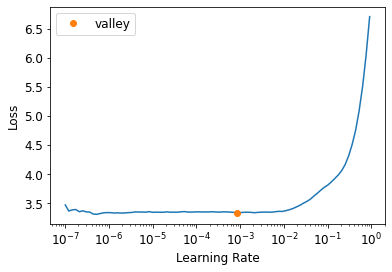

In [ ]:
learn.lr_find();

In [ ]:
learn.fit_one_cycle(5,0.001)

epoch,train_loss,valid_loss,accuracy,time
0,3.330883,3.640079,0.325903,00:11
1,3.254189,3.623593,0.324653,00:11
2,3.018371,3.680675,0.315347,00:11
3,2.710672,3.834084,0.311319,00:12
4,2.450310,3.926932,0.308750,00:11


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, 0.05)

epoch,train_loss,valid_loss,accuracy,time
0,3.513954,4.048078,0.275972,00:11
1,3.729149,3.930224,0.297708,00:11
2,3.622025,3.915103,0.291319,00:11
3,3.374561,3.878287,0.308056,00:11
4,2.910490,4.057989,0.304375,00:11


Predict the next 10 words:

In [ ]:
TEXT = "What are we "; N_WORDS = 10; N_SENTENCES = 2; 
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]
print("\n".join(preds))

What are we allowed to get 100 free followers ! # Gharwapsi
What are we Wrong ? Get ready for the next


Save the encoder

In [ ]:
learn.save_encoder('irony_enc')

Training the classifier using the language model

In [ ]:
#dls_clas = DataBlock(
#    blocks=(TextBlock.from_df('Tweet text',vocab=dls_lm.vocab),CategoryBlock),
#    get_x=ColReader('text'),
#    get_y=ColReader('label'),
#    splitter=ColSplitter())
#).dataloaders(df, bs=64)

clas = DataBlock(
    blocks=(TextBlock.from_df('Tweet text', vocab=dls_lm.vocab, seq_len=50),CategoryBlock),
    get_x=ColReader('text'),
    get_y = ColReader('Label'),
    splitter=ColSplitter())
dls_clas = clas.dataloaders(df, bs=32)

Carrega

In [ ]:
class_learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.3,metrics=accuracy)
class_learn.load_encoder('irony_enc')

In [ ]:
print("Fitting Classifier Object")
class_learn.fit_one_cycle(1, 1e-2)
print("Fitting Classifier Object after freezing all but last 2 layers")
class_learn.freeze_to(-2)
class_learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))
print("Fitting Classifier Object - discriminative learning")
class_learn.unfreeze()
class_learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))


Fitting Classifier Object


epoch,train_loss,valid_loss,accuracy,time
0,0.664405,0.642668,0.625205,00:07


Fitting Classifier Object after freezing all but last 2 layers


epoch,train_loss,valid_loss,accuracy,time
0,0.625203,0.632466,0.628478,00:07


Fitting Classifier Object - discriminative learning


epoch,train_loss,valid_loss,accuracy,time
0,0.513570,0.642536,0.639935,00:10


In [ ]:
class_learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.456618,0.678839,0.618658,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.443677,0.678316,0.654664,00:11
1,0.413129,0.707651,0.641571,00:10
2,0.408687,0.751930,0.656301,00:10
3,0.364237,0.767302,0.638298,00:10
4,0.326305,0.853961,0.625205,00:11
5,0.275324,0.897281,0.623568,00:11
6,0.250480,0.881085,0.617021,00:11
7,0.222500,0.917485,0.608838,00:11
8,0.213745,0.924667,0.621931,00:11
9,0.197715,0.913751,0.615385,00:11


Get the test set predictions

In [ ]:
pred_dl = dls_clas.test_dl(df_test['Tweet text'])

preds = class_learn.get_preds(dl=pred_dl, with_input=True)

In [ ]:
y_test = df_test['Label']

In [ ]:
y_pred = np.argmax(preds[1],axis=1)

print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.66      0.75      0.70       415
           1       0.66      0.56      0.61       369

    accuracy                           0.66       784
   macro avg       0.66      0.65      0.65       784
weighted avg       0.66      0.66      0.65       784

